# Task performance and engagement analysis

In [43]:
import json
import random
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.stats as st
from scipy import stats
from scipy.stats import binned_statistic
from scipy.special import expit, logit
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, LogisticRegression
import rpy2
from mycolorpy import colorlist as mcp
from matplotlib.cm import ScalarMappable
from datetime import datetime, timedelta

In [2]:
# Increase figure size a bit
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams.update({'font.size': 16})

## Load the data

In [3]:
# Open full filtered dataset
with open('../saved_analyses/AI_filter.txt', 'r') as filehandle:  
    games_filtered = json.load(filehandle)

In [4]:
# Load number of games per user
with open('../saved_analyses/numgames_user.txt', 'r') as filehandle:  
    num_games = json.load(filehandle)

## Relationship between learning and dropout

In [6]:
# Count the number of users who played at least 20 and less than 100 games
total_users = 0
for user in num_games:
    if num_games[user] < 100 and num_games[user] >= 20:
        total_users += 1

In [7]:
total_users

104681

In [8]:
# Put all users with at least 20 games in a set
over20_users = set()
for user in num_games:
    if num_games[user] >= 20:
        over20_users.add(user)
        
# Now create a dictionary with user IDs and each game path that corresponds to the user
over20_dict = dict((el,[]) for el in over20_users)

for game in games_filtered:
    ID = game[36:46]
    if ID in over20_users:
        over20_dict[ID].append(game)

In [10]:
# Write each cumulative block as a new user to a different PNG file (20 to final)
with open("eloinput_blocks.txt", "w") as elo_input:
    # Loop through each game, open the data file
    for userID, path_list in over20_dict.items():
        
        total_games = num_games[userID]
        num_blocks = np.floor(total_games/20)
        
        for j in range(int(num_blocks)):
            block_start = j*20
            block_end = block_start+20
        
            for i in range(block_start,block_end):
                game = path_list[i]
                with(open(game)) as f:
                    data = json.load(f)

                    # Set the new name for the user/block combo
                    human_name = str(data['bbuid']) + '_' + str(block_start)

                    # Grab the AI name
                    comp_name = str(data['data']['rankinit'])

                    # Get the game outcome
                    try:
                        game_outcome = data['data']['rounds'][-1]['analytic']['events'][-1]['resultString'] 
                    except:
                        print(game)

                    # Given the result set the correct format outcome
                    if game_outcome == "Win":
                        result_text = "1-0"
                    elif game_outcome == "Lose":
                        result_text = "0-1"
                    elif game_outcome == "Draw":
                        result_text = "1/2-1/2"

                    # Write the results to our output file
                    elo_input.write('[White "' + human_name + '"]\n[Black "' + comp_name + '"]\n[Result "' + 
                                        result_text + '"]\n' + result_text + '\n\n')

/Volumes/Samsung_T5/Peak/20190414/G/GtCfrEbctx-1538226896-537


In [9]:
# Set the path where the text file with Elo ratings is stored
elo_path = '/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/bayeselo/game_outcomes_peak_cogsci/ratings_blocks.txt'

# Set two regexp patterns to recognize user IDs and ratings in the text file
ID_pattern = re.compile(r"................\s{3}\d{4}")
rating_pattern = re.compile(r"\s{3}\d{4}")
winpercent_pattern = re.compile(r"\d{1}\s{1}..\d{1}.\d{1}\s{2}.\d{1}.\d{1}\s{2}")
opprating_pattern = re.compile(r"\d{1}\s{2}\d{4}\s{1}")

# Go through the text file and add all of the matching expressions to two lists
with open (elo_path, 'rt') as myfile:
    contents = myfile.read()
user_ID = ID_pattern.findall(contents)
user_ratings = rating_pattern.findall(contents)
user_winpercents = winpercent_pattern.findall(contents)
user_oppratings = opprating_pattern.findall(contents)

# For ratings, remove the whitespace and convert from strings to integers
ratings = [int(w[-4:]) for w in user_ratings]
winpercents = [float(w[2:7]) for w in user_winpercents]
oppratings = [int(w[-5:-1]) for w in user_oppratings]

# Remove the average overall AI elo rating from each rating (integer offsets don't matter)
mean_ai_elo = 3104
ratings_avg = [x - mean_ai_elo for x in ratings]
oppratings_avg = [x - mean_ai_elo for x in oppratings]

In [10]:
# Remove AI indices from the lists
AI_indices = [240552, 247920, 205945, 169906, 79650, 88142, 73111]
for index in sorted(AI_indices, reverse=True):
    del ratings_avg[index]
    del oppratings_avg[index]
    del winpercents[index]
    del user_ID[index]

In [ ]:
# Find the last 20 block ratings
ID_final = []
ratings_final = []
games_final = []

for userID in over20_dict.keys():
    total_games = num_games[userID]
    last_block = int(np.floor(total_games/20)*20-20)
    
    for ratingID in user_ID:
        if userID == ratingID[0:10] and last_block == int(ratingID[11:11+len(str(last_block))]):
            ratings_final.append(int(ratingID[-4:]))
            games_final.append(total_games)
            ID_final.append(userID)

ratings_final = [x - mean_ai_elo for x in ratings_final]

In [16]:
# Save out results
np.save("final20_ID.npy", ID_final)
np.save("final20_ratings.npy", ratings_final)
np.save("final20_games.npy", games_final)

In [61]:
# Load results
ID_final = np.load('../saved_analyses/final20_ID.npy', allow_pickle=True)
ratings_final = np.load('../saved_analyses/final20_ratings.npy', allow_pickle=True)
games_final = np.load('../saved_analyses/final20_games.npy', allow_pickle=True)

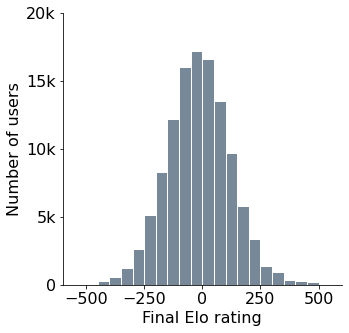

In [62]:
# Plot the histogram of final Elo ratings
bins = list(range(-600,600,50))

fig, ax = plt.subplots()
ax.hist(ratings_final, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Final Elo rating')
ax.set_ylabel('Number of users')
ax.set_xlim(-600,600)
ax.set_yticks([0, 5000, 10000, 15000, 20000])
ax.set_yticklabels(['0', '5k', '10k', '15k', '20k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elos_final.png', format='png', dpi=1000,bbox_inches = 'tight')

In [185]:
# Stats
st.spearmanr(games_final, ratings_final)

SpearmanrResult(correlation=0.2696231205102532, pvalue=0.0)

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  """


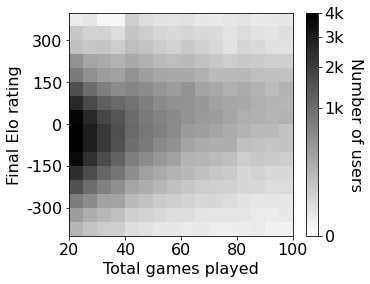

In [232]:
# Plot the correlation between Final Elo ratings and total games played
heatmap, xedges, yedges = np.histogram2d(games_final, ratings_final, range=[[20, 100], [-400, 400]], bins=16)

fig, ax = plt.subplots()

im = ax.imshow(heatmap.T, interpolation='nearest', origin='lower', cmap='gray_r', vmin=0, vmax=4000, norm=colors.PowerNorm(gamma=0.4))
ax.set_xlabel('Total games played')
ax.set_ylabel('Final Elo rating')
ax.set_xticks(np.arange(0-.5,20-.5,4))
ax.set_xticklabels(['20', '40', '60', '80', '100'])
ax.set_yticks(np.arange(0+1.5,16,3))
ax.set_yticklabels(['-300', '-150', '0', '150', '300'])

colorbar = plt.colorbar(im, shrink=0.82)
colorbar.ax.set_ylabel('Number of users', rotation=-90, va="bottom")
colorbar.set_ticks([np.arange(0,4000+1,1000)])
colorbar.set_ticklabels(['0','1k', '2k', '3k', '4k'])

# plt.savefig('elos_final_heatmap.png', format='png', dpi=1000,bbox_inches = 'tight')

In [19]:
# Find the first 20 block ratings
ID_initial = []
ratings_initial = []
games_initial = []

for userID in over20_dict.keys():
    total_games = num_games[userID]
    
    for ratingID in user_ID:
        if userID == ratingID[0:10] and int(ratingID[11]) == 0:
            ratings_initial.append(int(ratingID[-4:]))
            games_initial.append(total_games)
            ID_initial.append(userID)

ratings_initial = [x - mean_ai_elo for x in ratings_initial]

In [24]:
# Save out results
np.save("initial20_ID.npy", ID_initial)
np.save("initial20_ratings.npy", ratings_initial)
np.save("initial20_games.npy", games_initial)

In [4]:
# Load results
ID_initial = np.load('../saved_analyses/initial20_ID.npy', allow_pickle=True)
ratings_initial = np.load('../saved_analyses/initial20_ratings.npy', allow_pickle=True)
games_initial = np.load('../saved_analyses/initial20_games.npy', allow_pickle=True)

In [11]:
# Compute average and standard deviation of initial Elo ratings
np.average(ratings_initial), np.std(ratings_initial)

(-48.022971854304636, 124.93763057718853)

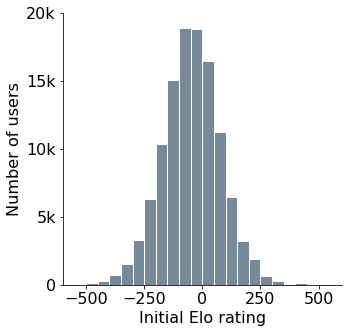

In [9]:
# Plot histogram of initial Elo ratings
bins = list(range(-600,600,50))

fig, ax = plt.subplots()
ax.hist(ratings_initial, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Initial Elo rating')
ax.set_ylabel('Number of users')
ax.set_xlim(-600,600)
ax.set_yticks([0, 5000, 10000, 15000, 20000])
ax.set_yticklabels(['0', '5k', '10k', '15k', '20k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elos_initial.png', format='png', dpi=1000,bbox_inches = 'tight')

In [10]:
# Stats
st.spearmanr(games_initial, ratings_initial)

SpearmanrResult(correlation=-0.02367481733377866, pvalue=7.427224445406813e-16)

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  """


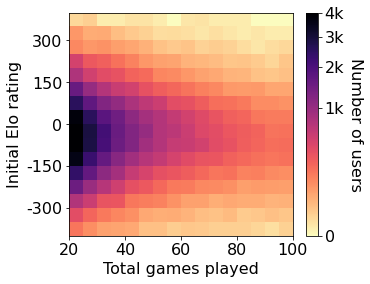

In [195]:
# Plot the correlation between initial Elo ratings and total games played
heatmap, xedges, yedges = np.histogram2d(games_initial, ratings_initial, range=[[20, 100], [-400, 400]], bins=16)

fig, ax = plt.subplots()

im = ax.imshow(heatmap.T, interpolation='nearest', origin='lower', cmap='magma_r', vmin=0, vmax=4000, norm=colors.PowerNorm(gamma=0.4))
ax.set_xlabel('Total games played')
ax.set_ylabel('Initial Elo rating')
ax.set_xticks(np.arange(0-.5,20-.5,4))
ax.set_xticklabels(['20', '40', '60', '80', '100'])
ax.set_yticks(np.arange(0+1.5,16,3))
ax.set_yticklabels(['-300', '-150', '0', '150', '300'])

colorbar = plt.colorbar(im, shrink=0.82)
colorbar.ax.set_ylabel('Number of users', rotation=-90, va="bottom")
colorbar.set_ticks([np.arange(0,4000+1,1000)])
colorbar.set_ticklabels(['0','1k', '2k', '3k', '4k'])

plt.show()
# plt.savefig('elos_initial_heatmap.png', format='png', dpi=1000,bbox_inches = 'tight')

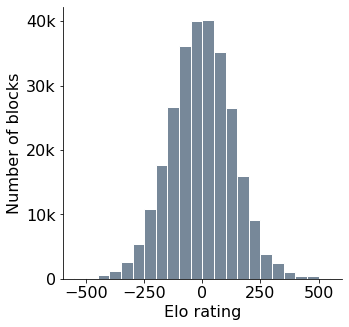

In [30]:
# Plot histogram of all Elo ratings
bins = list(range(-600,600,50))

fig, ax = plt.subplots()
ax.hist(ratings_avg, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Elo rating')
ax.set_ylabel('Number of blocks')
ax.set_xlim(-600,600)
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elos_all.png', format='png', dpi=1000,bbox_inches = 'tight')

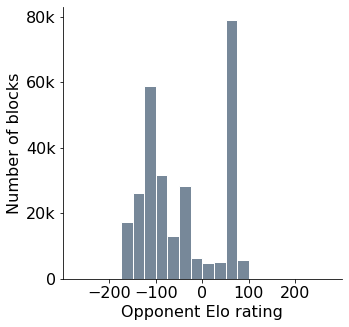

In [33]:
# Plot histogram of all opponent Elo ratings
bins = list(range(-300,300,25))

fig, ax = plt.subplots()
ax.hist(oppratings_avg, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Opponent Elo rating')
ax.set_ylabel('Number of blocks')
ax.set_xlim(-300,300)
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_yticks([0, 20000, 40000, 60000, 80000])
ax.set_yticklabels(['0', '20k', '40k', '60k', '80k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('oppelos_all.png', format='png', dpi=1000,bbox_inches = 'tight')

In [16]:
# Compute average and standard deviation of relative Elo ratings
np.average(np.asarray(ratings_avg)-np.asarray(oppratings_avg)), np.std(np.asarray(ratings_avg)-np.asarray(oppratings_avg))

(39.93790605374445, 126.9735305607857)

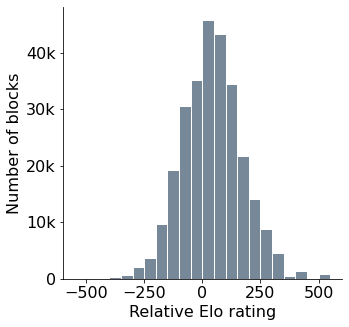

In [32]:
# Plot histogram of relative Elo ratings
bins = list(range(-600,600,50))

fig, ax = plt.subplots()
ax.hist(np.asarray(ratings_avg)-np.asarray(oppratings_avg), bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Relative Elo rating')
ax.set_ylabel('Number of blocks')
ax.set_xlim(-600,600)
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('relelos_all.png', format='png', dpi=1000,bbox_inches = 'tight')

In [26]:
# Load the player trajectories
trajectories_dict = np.load('../saved_analyses/trajectories_dict.npy', allow_pickle=True).flat[0]

In [36]:
# Load the opponent trajectories
opptrajectories_dict = np.load('../saved_analyses/opptrajectories_dict.npy', allow_pickle=True).flat[0]

In [35]:
# Compute the change in Elo ratings from the trajectories
changeelos = []
rel_changeelos = []

for userID in opptrajectories_dict.keys():
    curr_trajectory = trajectories_dict[userID]
    curr_opptrajectory = opptrajectories_dict[userID]
    for i in range(len(curr_trajectory)):
        if i == 0:
            pass
        else:
            diff_self = curr_trajectory[i]-curr_trajectory[i-1]
            diff_opp = curr_opptrajectory[i]-curr_opptrajectory[i-1]
            changeelos.append(diff_self)
            rel_changeelos.append(diff_self-diff_opp)


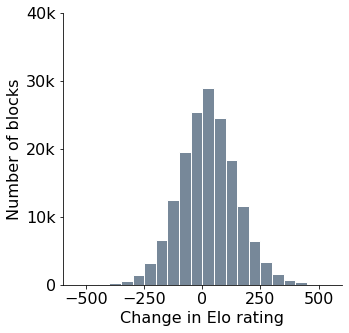

In [36]:
# Plot histogram of change in Elo ratings
bins = list(range(-600,600,50))

fig, ax = plt.subplots()
ax.hist(changeelos, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Change in Elo rating')
ax.set_ylabel('Number of blocks')
ax.set_xlim(-600,600)
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('changeelos_all.png', format='png', dpi=1000,bbox_inches = 'tight')

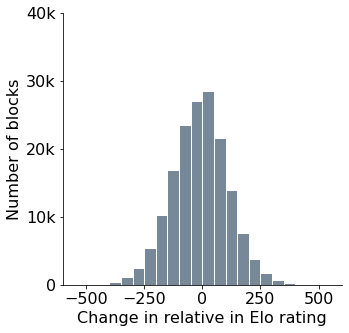

In [37]:
# Plot histogram of change in relative Elo ratings
bins = list(range(-600,600,50))

fig, ax = plt.subplots()
ax.hist(rel_changeelos, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Change in relative in Elo rating')
ax.set_ylabel('Number of blocks')
ax.set_xlim(-600,600)
ax.set_yticks([0, 10000, 20000, 30000, 40000])
ax.set_yticklabels(['0', '10k', '20k', '30k', '40k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
# plt.savefig('changerelelos_all.png', format='png', dpi=1000,bbox_inches = 'tight')

## Learning and dropout confound simulations

In [471]:
# Define a logistic function
def logistic_fun(x,x_0,k):
    return 1 / (1 + np.exp(-k*(x-x_0)))

In [849]:
# Draw inital Elo ratings from a Gaussian
mu, sigma = 0, 100
n_users = 100
elos = np.random.normal(mu, sigma, n_users)
# elos = np.abs(elos)

# Learning rate for Elos drawn from a LogNormal
sigma_lr = .1
p_stop = 0.05

# Loop over epochs
num_epochs = 80
all_elos = np.zeros((num_epochs+1, n_users))
all_elos[0,:] = elos
final_elos = np.zeros(n_users)
final_games = np.zeros(n_users)

for j in range(n_users):
    curr_elo = elos[j]
    for i in range(num_epochs):
        lr = np.random.lognormal(mu, sigma_lr)
        curr_elo += lr
        all_elos[i+1,j] = curr_elo
        
        p_cont = logistic_fun(curr_elo,-200,100)
        p = random.random()
        if p > p_cont or random.random() < p_stop:
            final_elos[j] = curr_elo
            final_games[j] = i
            break
        final_elos[j] = curr_elo
        final_games[j] = i

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [850]:
# Compute a polynomial fit
m, b = np.polyfit(final_games,final_elos, 1)
x_axis=np.linspace(0,81,80)
y_axis=b + m * x_axis

In [851]:
# Stats
st.spearmanr(final_games,final_elos)

SpearmanrResult(correlation=0.1846265007665852, pvalue=0.06593057154786476)

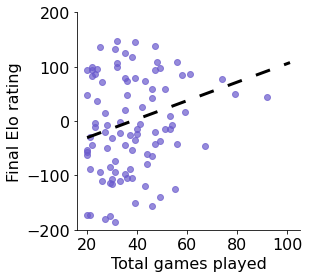

In [853]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(final_games, final_elos-np.average(final_elos), color='slateblue', alpha=0.7)
ax.plot(x_axis, y_axis-np.average(final_elos), lw=3, dashes = (5,5), color='black')
ax.set_ylabel('Final Elo rating')
ax.set_xlabel('Total games played')
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xticklabels(['20', '40', '60', '80', '100'])
ax.set_ylim(-200,200)
ax.set_yticks([-200, -100, 0, 100, 200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_bottomleft.png', format='png', dpi=1000,bbox_inches = 'tight')

In [844]:
# Draw inital Elo ratings from a Gaussian
mu, sigma = 0, 100
n_users = 100
elos = np.random.normal(mu, sigma, n_users)
# elos = np.abs(elos)

# Learning rate for Elos drawn from a LogNormal
sigma_lr = 1
p_stop = 0.05

# Loop over epochs
num_epochs = 80
all_elos = np.zeros((num_epochs+1, n_users))
all_elos[0,:] = elos
final_elos = np.zeros(n_users)
final_games = np.zeros(n_users)

for j in range(n_users):
    curr_elo = elos[j]
    for i in range(num_epochs):
        lr = np.random.lognormal(mu, sigma_lr)
        curr_elo += lr
        all_elos[i+1,j] = curr_elo
        
        p_cont = logistic_fun(curr_elo,200,100)
        p = random.random()
        if p > (1-p_cont) or random.random() < p_stop:
            final_elos[j] = curr_elo
            final_games[j] = i
            break
        final_elos[j] = curr_elo
        final_games[j] = i

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [845]:
# Compute a polynomial fit
m, b = np.polyfit(final_games,final_elos, 1)
x_axis=np.linspace(0,81,80)
y_axis=b + m * x_axis

In [846]:
# Stats
st.spearmanr(final_games,final_elos)

SpearmanrResult(correlation=0.1565123462122624, pvalue=0.119935106157077)

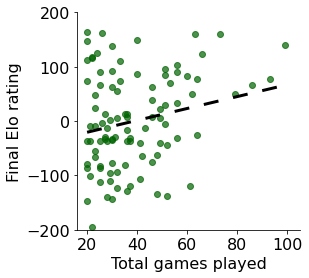

In [848]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(final_games, final_elos-np.average(final_elos), color='darkgreen', alpha=0.7)
ax.plot(x_axis, y_axis-np.average(final_elos), lw=3, dashes = (5,5), color='black')
ax.set_ylabel('Final Elo rating')
ax.set_xlabel('Total games played')
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xticklabels(['20', '40', '60', '80', '100'])
ax.set_ylim(-20,200)
ax.set_yticks([-200, -100, 0, 100, 200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_topright.png', format='png', dpi=1000,bbox_inches = 'tight')

## Learning

In [312]:
# Compute learning for total game groups
block20 = []
block40 = [[],[]]
block60 = [[],[],[]]
block80 = [[],[],[],[]]
block100 = [[],[],[],[],[]]
    
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 20:
            block20.append(curr_rating)

        elif block == 40:
            if ratingID[11] == '0':
                block40[0].append(curr_rating)
            elif ratingID[11:13] == '20':
                block40[1].append(curr_rating)

        elif block == 60:
            if ratingID[11] == '0':
                block60[0].append(curr_rating)
            elif ratingID[11:13] == '20':
                block60[1].append(curr_rating)
            elif ratingID[11:13] == '40':
                block60[2].append(curr_rating)

        elif block == 80:
            if ratingID[11] == '0':
                block80[0].append(curr_rating)
            elif ratingID[11:13] == '20':
                block80[1].append(curr_rating)
            elif ratingID[11:13] == '40':
                block80[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block80[3].append(curr_rating)

        elif block == 100:
            if ratingID[11] == '0':
                block100[0].append(curr_rating)
            elif ratingID[11:13] == '20':
                block100[1].append(curr_rating)
            elif ratingID[11:13] == '40':
                block100[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block100[3].append(curr_rating)
            elif ratingID[11:13] == '80':
                block100[4].append(curr_rating)

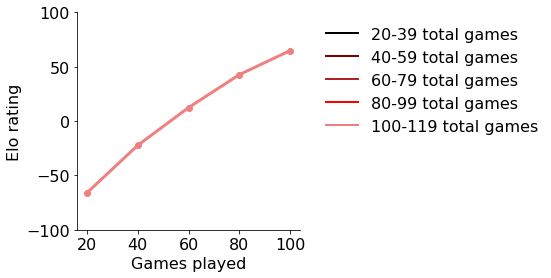

In [313]:
# Plot for 100-119 total games
colors = ['black', 'maroon', 'firebrick', 'red', 'lightcoral']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='20-39 total games'),Line2D([0], [0], color=colors[1], lw=2, label='40-59 total games'), Line2D([0], [0], color=colors[2], lw=2, label='60-79 total games'), Line2D([0], [0], color=colors[3], lw=2, label='80-99 total games'),Line2D([0], [0], color=colors[4], lw=2, label='100-119 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar([20,40,60,80,100], np.average(block100,axis=1), yerr = st.sem(block100,axis=1), marker='o', color='lightcoral',lw=3)
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_ylim(-100,100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('learning_119.png', format='png', dpi=1000,bbox_inches = 'tight')

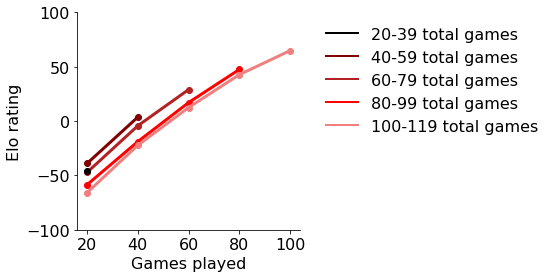

In [274]:
# Plot for all total games
colors = ['black', 'maroon', 'firebrick', 'red', 'lightcoral']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='20-39 total games'),Line2D([0], [0], color=colors[1], lw=2, label='40-59 total games'), Line2D([0], [0], color=colors[2], lw=2, label='60-79 total games'), Line2D([0], [0], color=colors[3], lw=2, label='80-99 total games'),Line2D([0], [0], color=colors[4], lw=2, label='100-119 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar([20,40], np.average(block40,axis=1), yerr = st.sem(block40,axis=1), marker='o', color='maroon', lw=3)
ax.errorbar([20,40,60], np.average(block60,axis=1),yerr = st.sem(block60,axis=1), marker='o', color='firebrick', lw=3)
ax.errorbar([20,40,60,80], np.average(block80,axis=1), yerr = st.sem(block80,axis=1), marker='o', color='red', lw=3)
ax.errorbar([20,40,60,80,100], np.average(block100,axis=1), yerr = st.sem(block100,axis=1), marker='o', color='lightcoral',lw=3)
ax.errorbar([20], np.average(block20), yerr = st.sem(block20), marker='o', color='black', lw=3)
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_ylim(-100,100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('learning.png', format='png', dpi=1000,bbox_inches = 'tight')

In [8]:
# Total number of users
len(block20)+len(block40[0])+len(block60[0])+len(block80[0])+len(block100[0])

107769

In [20]:
# Define function for regressions
def print_regression_table(X,y,regtype):
    
    if regtype == 'linear':
        lm = LinearRegression()
    elif regtype == 'logistic':
        lm = LogisticRegression()
    lm.fit(X,y)

    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values = [2 * (1 - st.t.cdf(np.abs(i), (len(newX) - len(newX.columns)))) for i in ts_b]

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    print(myDF3)

In [ ]:
# Group values needed for regression
initial_elos_all = []
current_elos_all = []
total_games_all = []
current_games_all = []
    
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        total_games_all.append(total_games)
        block = int(np.floor(total_games/20)*20)

        if block == 20:
            initial_elos_all.append(curr_rating)
            current_elos_all.append(curr_rating)
            current_games_all.append(int(ratingID[11]))
            
        else:
            current_elos_all.append(curr_rating)
            current_games_all.append(int(ratingID[11:13]))
            for matchID in user_ID:
                if matchID[0:10] == curr_user and matchID[11] == '0':
                    initial_elos_all.append(int(matchID[-4:])-mean_ai_elo)

In [ ]:
# Convert to array
initial_elos_all = np.asarray(initial_elos_all)
current_elos_all = np.asarray(current_elos_all)
total_games_all = np.asarray(total_games_all)
current_games_all = np.asarray(current_games_all)

In [157]:
# Compute a linear regression
x_all = np.stack((initial_elos_all, current_games_all, total_games_all)).T
print_regression_table(x_all, current_elos_all, 'linear')

   Coefficients  Standard Errors    t values  Probabilities
0      2.160736         0.277991    7.772696   7.771561e-15
1      0.664382         0.001596  416.405393   0.000000e+00
2      1.500082         0.008933  167.916672   0.000000e+00
3      0.018354         0.000273   67.150367   0.000000e+00


In [17]:
# Compute learning for extended total game groups
block100 = [[],[],[],[],[]]
block200 = [[],[],[],[],[],[],[],[],[],[]]
block300 = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
block400 = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
block500 = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 100 or block == 120 or block == 140 or block == 160 or block == 180:
            if ratingID[11] == '0':
                block100[0].append(curr_rating)
            elif ratingID[11:13] == '20':
                block100[1].append(curr_rating)
            elif ratingID[11:13] == '40':
                block100[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block100[3].append(curr_rating)
            elif ratingID[11:13] == '80':
                block100[4].append(curr_rating)
                
        elif block == 200 or block == 220 or block == 240 or block == 260 or block == 280:
            if ratingID[11] == '0':
                block200[0].append(curr_rating)
            elif ratingID[11:13] == '20' and ratingID[13] != '0':
                block200[1].append(curr_rating)
            elif ratingID[11:13] == '40':
                block200[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block200[3].append(curr_rating)
            elif ratingID[11:13] == '80':
                block200[4].append(curr_rating)
            elif ratingID[11:14] == '100':
                block200[5].append(curr_rating)
            elif ratingID[11:14] == '120':
                block200[6].append(curr_rating)
            elif ratingID[11:14] == '140':
                block200[7].append(curr_rating)
            elif ratingID[11:14] == '160':
                block200[8].append(curr_rating)
            elif ratingID[11:14] == '180':
                block200[9].append(curr_rating)
                
        elif block == 300 or block == 320 or block == 340 or block == 360 or block == 380:
            if ratingID[11] == '0':
                block300[0].append(curr_rating)
            elif ratingID[11:13] == '20' and ratingID[13] != '0':
                block300[1].append(curr_rating)
            elif ratingID[11:13] == '40':
                block300[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block300[3].append(curr_rating)
            elif ratingID[11:13] == '80':
                block300[4].append(curr_rating)
            elif ratingID[11:14] == '100':
                block300[5].append(curr_rating)
            elif ratingID[11:14] == '120':
                block300[6].append(curr_rating)
            elif ratingID[11:14] == '140':
                block300[7].append(curr_rating)
            elif ratingID[11:14] == '160':
                block300[8].append(curr_rating)
            elif ratingID[11:14] == '180':
                block300[9].append(curr_rating)
            elif ratingID[11:14] == '200':
                block300[10].append(curr_rating)
            elif ratingID[11:14] == '220':
                block300[11].append(curr_rating)
            elif ratingID[11:14] == '240':
                block300[12].append(curr_rating)
            elif ratingID[11:14] == '260':
                block300[13].append(curr_rating)
            elif ratingID[11:14] == '280':
                block300[14].append(curr_rating)
                
        elif block == 400 or block == 420 or block == 440 or block == 460 or block == 480:
            if ratingID[11] == '0':
                block400[0].append(curr_rating)
            elif ratingID[11:13] == '20' and ratingID[13] != '0':
                block400[1].append(curr_rating)
            elif ratingID[11:13] == '40' and ratingID[13] != '0':
                block400[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block400[3].append(curr_rating)
            elif ratingID[11:13] == '80':
                block400[4].append(curr_rating)
            elif ratingID[11:14] == '100':
                block400[5].append(curr_rating)
            elif ratingID[11:14] == '120':
                block400[6].append(curr_rating)
            elif ratingID[11:14] == '140':
                block400[7].append(curr_rating)
            elif ratingID[11:14] == '160':
                block400[8].append(curr_rating)
            elif ratingID[11:14] == '180':
                block400[9].append(curr_rating)
            elif ratingID[11:14] == '200':
                block400[10].append(curr_rating)
            elif ratingID[11:14] == '220':
                block400[11].append(curr_rating)
            elif ratingID[11:14] == '240':
                block400[12].append(curr_rating)
            elif ratingID[11:14] == '260':
                block400[13].append(curr_rating)
            elif ratingID[11:14] == '280':
                block400[14].append(curr_rating)
            elif ratingID[11:14] == '300':
                block400[15].append(curr_rating)
            elif ratingID[11:14] == '320':
                block400[16].append(curr_rating)
            elif ratingID[11:14] == '340':
                block400[17].append(curr_rating)
            elif ratingID[11:14] == '360':
                block400[18].append(curr_rating)
            elif ratingID[11:14] == '380':
                block400[19].append(curr_rating)
                
        elif block == 500 or block == 520 or block == 540 or block == 560 or block == 580:
            if ratingID[11] == '0':
                block500[0].append(curr_rating)
            elif ratingID[11:13] == '20' and ratingID[13] != '0':
                block500[1].append(curr_rating)
            elif ratingID[11:13] == '40' and ratingID[13] != '0':
                block500[2].append(curr_rating)
            elif ratingID[11:13] == '60':
                block500[3].append(curr_rating)
            elif ratingID[11:13] == '80':
                block500[4].append(curr_rating)
            elif ratingID[11:14] == '100':
                block500[5].append(curr_rating)
            elif ratingID[11:14] == '120':
                block500[6].append(curr_rating)
            elif ratingID[11:14] == '140':
                block500[7].append(curr_rating)
            elif ratingID[11:14] == '160':
                block500[8].append(curr_rating)
            elif ratingID[11:14] == '180':
                block500[9].append(curr_rating)
            elif ratingID[11:14] == '200':
                block500[10].append(curr_rating)
            elif ratingID[11:14] == '220':
                block500[11].append(curr_rating)
            elif ratingID[11:14] == '240':
                block500[12].append(curr_rating)
            elif ratingID[11:14] == '260':
                block500[13].append(curr_rating)
            elif ratingID[11:14] == '280':
                block500[14].append(curr_rating)
            elif ratingID[11:14] == '300':
                block500[15].append(curr_rating)
            elif ratingID[11:14] == '320':
                block500[16].append(curr_rating)
            elif ratingID[11:14] == '340':
                block500[17].append(curr_rating)
            elif ratingID[11:14] == '360':
                block500[18].append(curr_rating)
            elif ratingID[11:14] == '380':
                block500[19].append(curr_rating)
            elif ratingID[11:14] == '400':
                block500[20].append(curr_rating)
            elif ratingID[11:14] == '420':
                block500[21].append(curr_rating)
            elif ratingID[11:14] == '440':
                block500[22].append(curr_rating)
            elif ratingID[11:14] == '460':
                block500[23].append(curr_rating)
            elif ratingID[11:14] == '480':
                block500[24].append(curr_rating)

In [4]:
# Write each cumulative block for a human who always wins against increasingly strong AIs
with open("alwayswin_blocks.txt", "w") as alwayswin:
        
    total_games = 400
    num_blocks = np.floor(total_games/20)
    name = 'aaaaaaaaaa'
    AI_count = 1

    for j in range(int(num_blocks)):
        block_start = j*20
        block_end = block_start+20
        
        # Grab the AI name
        comp_name = str(AI_count)

        for i in range(block_start,block_end):
            
            human_name = name + '_' + str(block_start)
            
            # Given the result set the correct format outcome
            result_text = "1-0"

            # Write the results to our output file
            alwayswin.write('[White "' + human_name + '"]\n[Black "' + comp_name + '"]\n[Result "' + 
                                result_text + '"]\n' + result_text + '\n\n')
        if AI_count < 7:
            AI_count += 1

In [22]:
# Set the path where the text file with elo ratings is stored
elo_path = '/Users/ionatankuperwajs/Desktop/MaLab/Peak/Code/bayeselo/game_outcomes_peak_paper/ratings_blocks_mod.txt'

# Set two regexp patterns to recognize user IDs and ratings in the text file
ID_pattern = re.compile(r"................\s{3}\d{4}")
rating_pattern = re.compile(r"\s{3}\d{4}")
winpercent_pattern = re.compile(r"\d{1}\s{1}..\d{1}.\d{1}\s{2}.\d{1}.\d{1}\s{2}")
opprating_pattern = re.compile(r"\d{1}\s{2}\d{4}\s{1}")

# Go through the text file and add all of the matching expressions to two lists
with open (elo_path, 'rt') as myfile:
    contents = myfile.read()
user_ID = ID_pattern.findall(contents)
user_ratings = rating_pattern.findall(contents)
user_winpercents = winpercent_pattern.findall(contents)
user_oppratings = opprating_pattern.findall(contents)

# For ratings, remove the whitespace and convert from strings to integers
ratings = [int(w[-4:]) for w in user_ratings]
winpercents = [float(w[2:7]) for w in user_winpercents]
oppratings = [int(w[-5:-1]) for w in user_oppratings]

# Remove the average overall AI elo rating from each rating (integer offsets don't matter)
mean_ai_elo = 3104
ratings_avg = [x - mean_ai_elo for x in ratings]
oppratings_avg = [x - mean_ai_elo for x in oppratings]

In [27]:
# Now find the upper bound trajectory
total_games = 400
last_block = int(np.floor(total_games/20)*20)
ub_trajectory = []
ub_opptrajectory = []

for ii in range(0,last_block,20):
    idx = 0
    for ratingID in user_ID:
        if ratingID[0:10] == 'aaaaaaaaaa' and ii == int(ratingID[11:11+len(str(ii))+1]):
            ub_trajectory.append(ratings_avg[idx])
            ub_opptrajectory.append(oppratings_avg[idx])
        idx += 1

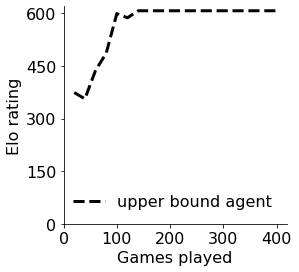

In [37]:
# Plot the upper bound trajectory
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.arange(20,420,20), ub_trajectory, color='black',ls='--',lw=3, label='upper bound agent')

ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([0, 100, 200, 300, 400])
ax.set_yticks([0, 150, 300, 450, 600])
ax.legend(frameon = False, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('learning_ub.png', format='png', dpi=1000,bbox_inches = 'tight')

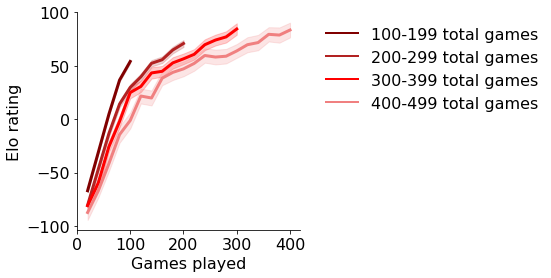

In [35]:
# Plot the extended learning curves
colors = ['maroon', 'firebrick', 'red', 'lightcoral']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='100-199 total games'),Line2D([0], [0], color=colors[1], lw=2, label='200-299 total games'), Line2D([0], [0], color=colors[2], lw=2, label='300-399 total games'), Line2D([0], [0], color=colors[3], lw=2, label='400-499 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar(np.arange(20,120,20), np.average(block100,axis=1), color='maroon',lw=3)
ax.errorbar(np.arange(20,220,20), np.average(block200,axis=1), color='firebrick',lw=3)
ax.errorbar(np.arange(20,320,20), np.average(block300,axis=1), color='red',lw=3)
ax.errorbar(np.arange(20,420,20), np.average(block400,axis=1), color='lightcoral',lw=3)

ax.fill_between(np.arange(20,120,20), np.average(block100,axis=1)-st.sem(block100,axis=1), np.average(block100,axis=1)+st.sem(block100,axis=1), color='maroon', alpha=0.2)
ax.fill_between(np.arange(20,220,20), np.average(block200,axis=1)-st.sem(block200,axis=1), np.average(block200,axis=1)+st.sem(block200,axis=1), color='firebrick', alpha=0.2)
ax.fill_between(np.arange(20,320,20), np.average(block300,axis=1)-st.sem(block300,axis=1), np.average(block300,axis=1)+st.sem(block300,axis=1), color='red', alpha=0.2)
ax.fill_between(np.arange(20,420,20), np.average(block400,axis=1)-st.sem(block400,axis=1), np.average(block400,axis=1)+st.sem(block400,axis=1), color='lightcoral', alpha=0.2)

ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([0, 100, 200, 300, 400])
ax.set_yticks([-100, -50, 0, 50, 100])
# ax.set_xticklabels(['20', '40', '60', '80', '100'])
# ax.set_ylim(-120,200)
# ax.set_yticks([-100, 0, 100, 200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('learning_coarse.png', format='png', dpi=1000,bbox_inches = 'tight')

## Dropout

In [10]:
# Compute dropout values for regression
elo_all = []
games_all = []
stop_all = []

for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        if ratingID[11] == '0':
            if total_games < 40:
                stop_all.append(1)
                elo_all.append(curr_rating)
                games_all.append(20)
            else:
                stop_all.append(0)
                elo_all.append(curr_rating)
                games_all.append(20)
        elif ratingID[11:13] == '20':
            if total_games < 60:
                stop_all.append(1)
                elo_all.append(curr_rating)
                games_all.append(40)
            else:
                stop_all.append(0)
                elo_all.append(curr_rating)
                games_all.append(40)
        elif ratingID[11:13] == '40':
            if total_games < 80:
                stop_all.append(1)
                elo_all.append(curr_rating)
                games_all.append(60)
            else:
                stop_all.append(0)
                elo_all.append(curr_rating)
                games_all.append(60)
        elif ratingID[11:13] == '60':
            if total_games < 100:
                stop_all.append(1)
                elo_all.append(curr_rating)
                games_all.append(80)
            else:
                stop_all.append(0)
                elo_all.append(curr_rating)
                games_all.append(80)
        elif ratingID[11:13] == '80':
            if total_games < 120:
                stop_all.append(1)
                elo_all.append(curr_rating)
                games_all.append(100)
            else:
                stop_all.append(0)
                elo_all.append(curr_rating)
                games_all.append(100)
                
elo_all = np.asarray(elo_all)
games_all = np.asarray(games_all)
stop_all = np.asarray(stop_all)

7         
5         
6         
4         
3         
1         
2         


In [10]:
# Compute a logistic regression
x_all2 = np.stack((elo_all, games_all)).T
print_regression_table(x_all2, stop_all, 'logistic')

   Coefficients  Standard Errors    t values  Probabilities
0      0.707345         0.002624  269.589037            0.0
1      0.000631         0.000010   62.391100            0.0
2     -0.020227         0.000058 -350.079642            0.0


In [6]:
# Load the trajectories
trajectories_dict = np.load('../saved_analyses/trajectories_dict.npy', allow_pickle=True).flat[0]

In [7]:
# Group the Elos from the trajectories
games_played = []
stopping = []

for userID in trajectories_dict.keys():
    curr_trajectory = trajectories_dict[userID]
    for i in range(len(curr_trajectory)):
        games_played.append(i*20+20)
        if i != len(curr_trajectory)-1:
            stopping.append(0)
        else:
            stopping.append(1)

In [8]:
# Compute the mean and sem binned for stopping vs. games played
bin_means, bin_edges, binnumber = binned_statistic(games_played, stopping, statistic='mean', bins=10, range=(0, 200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(games_played, stopping, statistic=st.sem, bins=10, range=(0, 200))

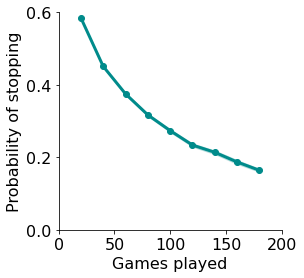

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='darkcyan', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='darkcyan', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Games played')
ax.set_ylim(0,0.6)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('stopping_games.png', format='png', dpi=1000,bbox_inches = 'tight')

In [10]:
# Group the Elos from the trajectories
elos = []
stopping = []

for userID in trajectories_dict.keys():
    curr_trajectory = trajectories_dict[userID]
    for i in range(len(curr_trajectory)):
        elos.append(curr_trajectory[i])
        if i != len(curr_trajectory)-1:
            stopping.append(0)
        else:
            stopping.append(1)

In [11]:
# Compute the mean and sem binned for stopping vs. elo
bin_means, bin_edges, binnumber = binned_statistic(elos, stopping, statistic='mean', bins=10, range=(-500, 500))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(elos, stopping, statistic=st.sem, bins=10, range=(-500, 500))

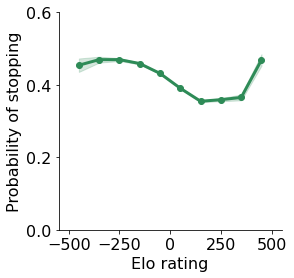

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1]+50, bin_means, marker='o', color='seagreen', lw=3)
ax.fill_between(bin_edges[:-1]+50, bin_means-bin_sem, bin_means+bin_sem, color='seagreen', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Elo rating')
ax.set_xlim(-550,550)
ax.set_ylim(0,0.6)
ax.set_xticks([-500, -250, 0, 250, 500])
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('stopping_elo.png', format='png', dpi=1000,bbox_inches = 'tight')

In [13]:
# Compute the change in Elos from the trajectories
change_elos = []
stopping = []

for userID in trajectories_dict.keys():
    curr_trajectory = trajectories_dict[userID]
    for i in range(len(curr_trajectory)):
        if i == 0:
            pass
        else:
            change_elos.append(curr_trajectory[i]-curr_trajectory[i-1])
            if i != len(curr_trajectory)-1:
                stopping.append(0)
            else:
                stopping.append(1)

In [14]:
# Compute the mean and sem binned for stopping vs. change in elo
bin_means, bin_edges, binnumber = binned_statistic(change_elos, stopping, statistic='mean', bins=10, range=(-500, 500))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(change_elos, stopping, statistic=st.sem, bins=10, range=(-500, 500))

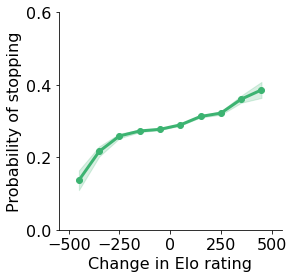

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1]+50, bin_means, marker='o', color='mediumseagreen', lw=3)
ax.fill_between(bin_edges[:-1]+50, bin_means-bin_sem, bin_means+bin_sem, color='mediumseagreen', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Change in Elo rating')
ax.set_xlim(-550,550)
ax.set_ylim(0,0.6)
ax.set_xticks([-500, -250, 0, 250, 500])
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('stopping_change.png', format='png', dpi=1000,bbox_inches = 'tight')

In [783]:
# Compute the mean and sem binned for change in elo vs. games played
bin_means, bin_edges, binnumber = binned_statistic(games_played, change_elos, statistic='mean', bins=25, range=(40, 540))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(games_played, change_elos, statistic=st.sem, bins=25, range=(40, 540))

In [784]:
# Test that the bins are equivalent to averaging
np.mean(np.asarray(change_elos)[np.where(np.asarray(games_played)==40)])

47.90318963369051

In [21]:
# Compute a logistic regression
print_regression_table(np.asarray(change_elos).reshape(-1,1), stopping, 'logistic')

   Coefficients  Standard Errors    t values  Probabilities
0     -0.914182         0.001346 -679.380556            0.0
1      0.000784         0.000011   74.407005            0.0


## Validating Elo ratings as a measure of task performance

In [788]:
# Compute the correlation between Elo ratings and win percentages
st.spearmanr(ratings_avg, winpercents)

SpearmanrResult(correlation=0.7080578312199157, pvalue=0.0)

In [789]:
# Group the Elo ratings and win percentages by block
elo_percents_mean = []
elo_percents_sem = []
elo_percents_density = []

for i in range(0,101,5):
    elo_percents_mean.append(np.mean(np.asarray(ratings_avg)[np.where(np.asarray(winpercents)==i)]))
    elo_percents_sem.append(st.sem(np.asarray(ratings_avg)[np.where(np.asarray(winpercents)==i)]))
    elo_percents_density.append(len(np.asarray(ratings_avg)[np.where(np.asarray(winpercents)==i)]))

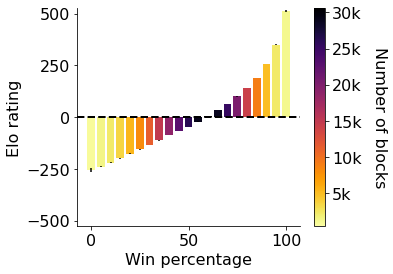

In [794]:
# Plot
data_color = [x / max(elo_percents_density) for x in elo_percents_density]

my_cmap = plt.cm.get_cmap('inferno_r')
colors = my_cmap(data_color)

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(np.arange(0,101,5), elo_percents_mean, yerr=elo_percents_sem, width=4, color=colors)
ax.set_yticks([-500, -250, 0, 250, 500])
ax.axhline(y = 0.5, color = 'black', linestyle = '--', lw=2)
ax.set_ylim(-525,525)
ax.set_xlabel('Win percentage')
ax.set_ylabel('Elo rating')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(min(elo_percents_density),max(elo_percents_density)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Number of blocks', rotation=-90,labelpad=25)
cbar.set_ticks(np.arange(0,30000+1,5000))
cbar.set_ticklabels(['0','5k', '10k', '15k', '20k', '25k', '30k'])

# plt.savefig('elos_winpercent.png', format='png', dpi=1000,bbox_inches = 'tight')

In [34]:
# Compute win/loss streaks before dropout
all_streaks = []

# Loop through each game, open the data file
for userID, path_list in over20_dict.items():
    
    total_games = num_games[userID]
    streak = True
    i = total_games-1
    user_streak = 0
    
    while streak == True and i >= 0:
        game = path_list[i]
        with(open(game)) as f:
            data = json.load(f)
            
            # Get the game outcome
            try:
                game_outcome = data['data']['rounds'][-1]['analytic']['events'][-1]['resultString']
            except:
                print(game)
                
            # Given the result set the correct outcome
            if i == total_games-1:
                if game_outcome == "Win":
                    user_streak += 1
                    i -= 1
                elif game_outcome == "Lose":
                    user_streak -= 1
                    i -= 1
                elif game_outcome == "Draw":
                    user_streak += 0
                    i -= 1
            else:
                if user_streak > 0 and game_outcome == "Win":
                    user_streak += 1
                    i -= 1
                elif user_streak < 0 and game_outcome == "Lose":
                    user_streak -= 1
                    i -= 1
                elif user_streak == 0 and game_outcome == "Draw":
                    user_streak += 0
                    i -= 1
                elif user_streak > 0 and game_outcome != "Win":
                    streak = False
                elif user_streak < 0 and game_outcome != "Lose":
                    streak = False
                elif user_streak == 0 and game_outcome != "Draw":
                    streak = False
                    
    all_streaks.append(user_streak)

In [53]:
# Save out the streaks
np.save("quit_streaks.npy", all_streaks)

In [98]:
# Load the streaks
all_streaks = np.load('../saved_analyses/quit_streaks.npy', allow_pickle=True)

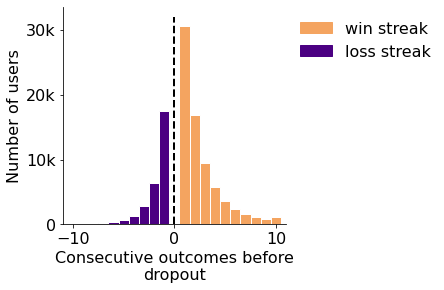

In [89]:
# Plot
bins = list(range(-10,12,1))
streak_hist, streak_bins = np.histogram(all_streaks, bins)
streak_hist[10] = 0

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(np.arange(1,11), streak_hist[11:22], edgecolor='white', color='sandybrown', width=1)
ax.bar(np.arange(-10,0), streak_hist[0:10], edgecolor='white', color='indigo', width=1)
ax.vlines(0,0,32000,linewidth=2,linestyle='--',color='black')
ax.set_xlabel('Consecutive outcomes before\ndropout')
ax.set_ylabel('Number of users')
ax.set_xlim(-11,11)
ax.set_yticks([0, 10000, 20000, 30000])
ax.set_yticklabels(['0', '10k', '20k', '30k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legend_elements = [Patch(facecolor='sandybrown', edgecolor='sandybrown',
                         label='win streak'),
                   Patch(facecolor='indigo', edgecolor='indigo',
                         label='loss streak')]

ax.legend(handles=legend_elements,bbox_to_anchor=(1,1),loc='upper left',frameon=False)

# plt.savefig('streak_dist.png', format='png', dpi=1000,bbox_inches = 'tight')

## Time

In [34]:
# Load the times and IGIs
with open('../saved_analyses/times.txt', 'r') as filehandle:  
    times_played = json.load(filehandle)

with open('../saved_analyses/IGI.txt', 'r') as filehandle:  
    time_elapsed = json.load(filehandle)

In [35]:
len(times_played)

1234844

In [36]:
# Filter the times
for user in list(times_played):
    for time in times_played[user]:
        if int(time[0:4]) > 2019:
            times_played.pop(user)
            break
        elif int(time[0:4]) == 2019 and int(time[5:7]) > 4:
            times_played.pop(user)
            break
        

In [37]:
len(times_played)

1234774

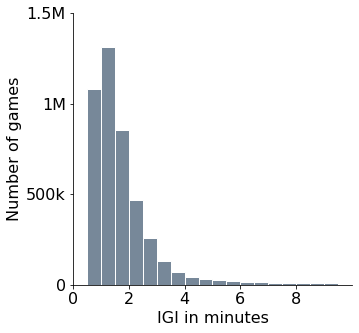

In [38]:
# Plot the range of IGIs in minutes
time_elapsed_mins = (np.asarray(time_elapsed)/60)

bins = np.arange(0,10,.5)

fig, ax = plt.subplots()
ax.hist(time_elapsed_mins, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('IGI in minutes')
ax.set_ylabel('Number of games')
ax.set_xlim(0,10)
ax.set_xticks([0,2,4,6,8])
ax.set_yticks([0,500000, 1000000, 1500000])
ax.set_yticklabels(['0','500k', '1M', '1.5M'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# plt.savefig('IGI_dist.png', format='png', dpi=1000,bbox_inches = 'tight')

In [39]:
# Function that computes the difference in time given two timestamps
def get_IGI(time1,time2):
    
    # Datetime object (year, month, hour, min, sec)
    date1 = datetime(int(time1[0:4]),int(time1[5:7]),int(time1[8:10]),int(time1[11:13])
                              ,int(time1[14:16]),int(time1[17:19]))
    date2 = datetime(int(time2[0:4]),int(time2[5:7]),int(time2[8:10]),int(time2[11:13])
                             ,int(time2[14:16]),int(time2[17:19]))
    
    # Return the difference in seconds
    total_diff = date1-date2
    sec_diff = total_diff.days*86400+total_diff.seconds
    
    return sec_diff

In [40]:
# For each user who played at least 20 games, compute the time from start
IGI_start20 = {}
for key in over20_dict.keys():
    if key in times_played.keys():
        IGI_start20[key] = []

for userID in IGI_start20.keys():
    start_date = '2018-09-01T00:00:00-00:00'
    for game_time in times_played[userID]:
        time_diff = get_IGI(game_time,start_date)
        IGI_start20[userID].append(((time_diff/60)/60)/24)

In [157]:
# Take a sample of users to plot
raster_sample = random.sample(list(IGI_start20.values()), 50)
raster_sample.sort(key = len)
raster_sample = [[ele for ele in sub if ele != 0] for sub in raster_sample]

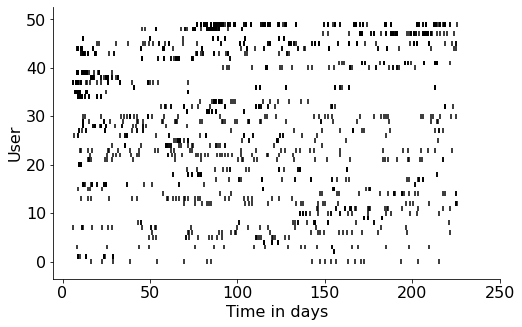

In [159]:
fig, ax = plt.subplots(figsize=(8,5))
ax.eventplot(raster_sample, color='black')

ax.set_xticks([0, 50, 100, 150, 200, 250])
ax.set_xlabel('Time in days')
ax.set_ylabel('User')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('raster.png', format='png', dpi=1000,bbox_inches = 'tight')

In [41]:
# For each user who played at least 20 games, compute the IGI std and mean
IGI_stds = []
IGI_means = []

for userID in IGI_start20.keys():
    user_IGI = []
    for game in range(len(times_played[userID])-1):
        time_diff = get_IGI(times_played[userID][game+1],times_played[userID][game])
        user_IGI.append((time_diff/60)/60)
    IGI_stds.append(np.std(user_IGI))
    IGI_means.append(np.average(user_IGI))

Text(0, 0.5, 'Number of users')

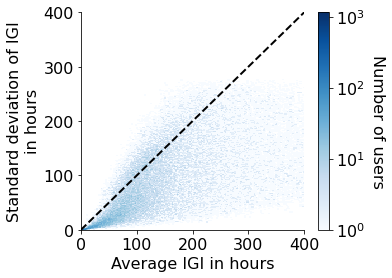

In [44]:
# Plot
fig, ax = plt.subplots(figsize=(5,4))
plot = ax.hist2d(IGI_stds, IGI_means, bins=(500, 500), cmap=plt.cm.Blues, norm = colors.LogNorm())
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', lw=2, ls='--')
ax.set_ylabel('Standard deviation of IGI\nin hours')
ax.set_xlabel('Average IGI in hours')
ax.set_xlim(0,400)
ax.set_ylim(0,400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cbar = plt.colorbar(plot[3])
cbar.minorticks_off()
cbar.ax.set_ylabel('Number of users', rotation=-90, labelpad=20)

# plt.savefig('coeff_density.png', format='png', dpi=1000,bbox_inches = 'tight')

In [45]:
# Stats
stats.ttest_ind(IGI_stds, IGI_means)

Ttest_indResult(statistic=159.61389316563384, pvalue=0.0)

In [46]:
# Compute the IGI coefficient
IGI_coeff = np.asarray(IGI_stds)/np.asarray(IGI_means)
np.average(IGI_coeff), np.var(IGI_coeff)

(2.2445620582334733, 2.2131697575752596)

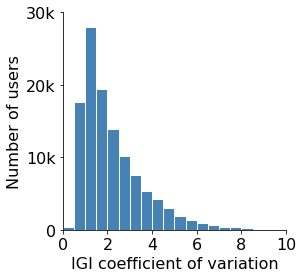

In [64]:
# Plot histogram of IGI coefficients
bins = list(np.arange(0,10.01,0.5))

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(IGI_coeff, bins, edgecolor='white', color='steelblue')
ax.set_xlabel('IGI coefficient of variation')
ax.set_ylabel('Number of users')
ax.set_xlim(0,10)
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0, 10000, 20000, 30000])
ax.set_yticklabels(['0', '10k', '20k', '30k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('coeff_distribution.png', format='png', dpi=1000,bbox_inches = 'tight')

In [32]:
# Compute the gap between first and last play
IGI_startend = []

for userID in times_played.keys():
    time_diff = get_IGI(times_played[userID][len(times_played[userID])-1],times_played[userID][0])
    IGI_startend.append(((time_diff/60)/60)/24)

In [59]:
# Max gap
np.max(IGI_startend)

261.42859953703703

In [57]:
# Average gap
np.average(IGI_startend)

34.44834396026865

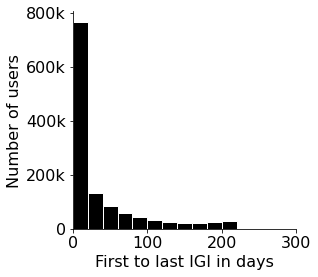

In [163]:
# Plot
bins = list(range(0,300,20))

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(IGI_startend, bins, edgecolor='white', color='black')
ax.set_xlabel('First to last IGI in days')
ax.set_ylabel('Number of users')
ax.set_xlim(0,300)
ax.set_yticks([0, 200000, 400000, 600000, 800000])
ax.set_yticklabels(['0', '200k', '400k', '600k', '800k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('firstlast_distribution.png', format='png', dpi=1000,bbox_inches = 'tight')

In [33]:
# Compute last game time to end date
latest_date = '2019-05-01T00:00:00+00:00'

IGI_endgap = []

for userID in times_played.keys():
    time_diff = get_IGI(latest_date, times_played[userID][len(times_played[userID])-1])
    if time_diff > 0:
        IGI_endgap.append(((time_diff/60)/60)/24)           

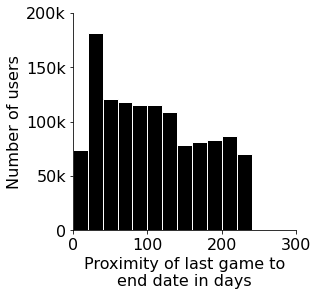

In [164]:
# Plot
bins = list(range(0,300,20))

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(IGI_endgap, bins, edgecolor='white', color='black')
ax.set_xlabel('Proximity of last game to\nend date in days')
ax.set_ylabel('Number of users')
ax.set_xlim(0,300)
ax.set_yticks([0, 50000, 100000, 150000, 200000])
ax.set_yticklabels(['0', '50k', '100k', '150k', '200k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('endgap_distribution.png', format='png', dpi=1000,bbox_inches = 'tight')

In [39]:
# Compute relationship between previous two values
IGI_endgap_comp = []
IGI_startend_comp = []

for userID in times_played.keys():
    time_diff = get_IGI(latest_date, times_played[userID][len(times_played[userID])-1])
    if time_diff > 0:
        IGI_endgap_comp.append(((time_diff/60)/60)/24) 
        
    time_diff = get_IGI(times_played[userID][len(times_played[userID])-1],times_played[userID][0])
    IGI_startend_comp.append(((time_diff/60)/60)/24)

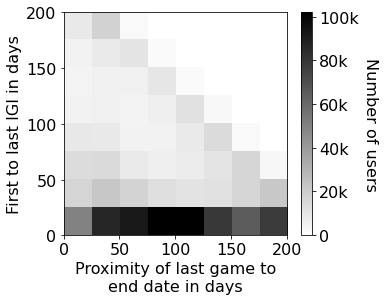

In [87]:
# Plot
heatmap, xedges, yedges = np.histogram2d(IGI_endgap_comp, IGI_startend_comp, range=[[0,200], [0,200]], bins=8)

fig, ax = plt.subplots()

im = ax.imshow(heatmap.T, interpolation='nearest', origin='lower', cmap='gray_r')
ax.set_xlabel('Proximity of last game to\nend date in days')
ax.set_ylabel('First to last IGI in days')
ax.set_xticks(np.arange(0-.5,9-.5,2))
ax.set_xticklabels(['0', '50', '100', '150', '200'])
ax.set_yticks(np.arange(0-.5,9-.5,2))
ax.set_yticklabels(['0', '50', '100', '150', '200'])

colorbar = plt.colorbar(im, shrink=0.82)
colorbar.ax.set_ylabel('Number of users', rotation=-90, va="bottom")
colorbar.set_ticks([0, 20000, 40000, 60000, 80000, 100000])
colorbar.set_ticklabels(['0','20k', '40k', '60k', '80k', '100k'])

# plt.savefig('endgap_heatmap.png', format='png', dpi=1000,bbox_inches = 'tight')

In [168]:
# For each user, find the final Elo rating, average gap between games, and total games played
IGI_ID = []
IGI_gap = []
IGI_ratings = []
IGI_games = []

for userID in IGI_start20.keys():
    total_games = num_games[userID]
    last_block = int(np.floor(total_games/20)*20-20)
    
    for ratingID in user_ID:
        if userID == ratingID[0:10] and last_block == int(ratingID[11:11+len(str(last_block))]):
            IGI_ratings.append(int(ratingID[-4:]))
            IGI_games.append(total_games)
            IGI_ID.append(userID)
            avg_IGI = 0
            count = 0
            for game in range(len(times_played[userID])-1):
                time_diff = get_IGI(times_played[userID][game+1],times_played[userID][game])
                avg_IGI += time_diff
                count += 1
            IGI_gap.append(avg_IGI/count)
            
mean_ai_elo = 3104
IGI_ratings = [x - mean_ai_elo for x in IGI_ratings]

In [169]:
# Save out the IGI data
np.save("IGI_ID.npy", IGI_ID)
np.save("IGI_gap.npy", IGI_gap)
np.save("IGI_ratings.npy", IGI_ratings)
np.save("IGI_games.npy", IGI_games)

In [49]:
# Load the IGI data
IGI_ID = np.load('../saved_analyses/IGI_ID.npy', allow_pickle=True)
IGI_gap = np.load('../saved_analyses/IGI_gap.npy', allow_pickle=True)
IGI_ratings = np.load('../saved_analyses/IGI_ratings.npy', allow_pickle=True)
IGI_games = np.load('../saved_analyses/IGI_games.npy', allow_pickle=True)

In [12]:
# Compute IGI and rating for each block
blocks = [20, 40, 60, 80, 100]

gaps_20 = []
ratings_20 = []
gaps_40 = []
ratings_40 = []
gaps_60 = []
ratings_60 = []
gaps_80 = []
ratings_80 = []
gaps_100 = []
ratings_100 = []

for i in blocks:
    idxs = np.where((np.asarray(IGI_games) >= i) & (np.asarray(IGI_games) <= i+19))
    if i == 20:
        gaps_20 = (np.asarray(IGI_gap)[idxs[0]]/60)/60
        ratings_20 = np.asarray(IGI_ratings)[idxs[0]]
    elif i == 40:
        gaps_40 = (np.asarray(IGI_gap)[idxs[0]]/60)/60
        ratings_40 = np.asarray(IGI_ratings)[idxs[0]]
    elif i == 60:
        gaps_60 = (np.asarray(IGI_gap)[idxs[0]]/60)/60
        ratings_60 = np.asarray(IGI_ratings)[idxs[0]]
    elif i == 80:
        gaps_80 = (np.asarray(IGI_gap)[idxs[0]]/60)/60
        ratings_80 = np.asarray(IGI_ratings)[idxs[0]]
    elif i == 100:
        gaps_100 = (np.asarray(IGI_gap)[idxs[0]]/60)/60
        ratings_100 = np.asarray(IGI_ratings)[idxs[0]]

In [200]:
# Compute the averages per block
range_tuple=(0, 55)

bin_means20, bin_edges, binnumber = binned_statistic(gaps_20, ratings_20, statistic='mean', bins=10, range=range_tuple)
bin_sem20, bin_edges_sem, binnumber_sem = binned_statistic(gaps_20, ratings_20, statistic=st.sem, bins=10, range=range_tuple)

bin_means40, bin_edges, binnumber = binned_statistic(gaps_40, ratings_40, statistic='mean', bins=10, range=range_tuple)
bin_sem40, bin_edges_sem, binnumber_sem = binned_statistic(gaps_40, ratings_40, statistic=st.sem, bins=10, range=range_tuple)

bin_means60, bin_edges, binnumber = binned_statistic(gaps_60, ratings_60, statistic='mean', bins=10, range=range_tuple)
bin_sem60, bin_edges_sem, binnumber_sem = binned_statistic(gaps_60, ratings_60, statistic=st.sem, bins=10, range=range_tuple)

bin_means80, bin_edges, binnumber = binned_statistic(gaps_80, ratings_80, statistic='mean', bins=10, range=range_tuple)
bin_sem80, bin_edges_sem, binnumber_sem = binned_statistic(gaps_80, ratings_80, statistic=st.sem, bins=10, range=range_tuple)

bin_means100, bin_edges, binnumber = binned_statistic(gaps_100, ratings_100, statistic='mean', bins=10, range=range_tuple)
bin_sem100, bin_edges_sem, binnumber_sem = binned_statistic(gaps_100, ratings_100, statistic=st.sem, bins=10, range=range_tuple)


In [72]:
# Group the 40-100 blocks together for stats
gaps_40100 = []
gaps_40100.extend(gaps_40)
gaps_40100.extend(gaps_60)
gaps_40100.extend(gaps_80)
gaps_40100.extend(gaps_100)

ratings_40100 = []
ratings_40100.extend(ratings_40)
ratings_40100.extend(ratings_60)
ratings_40100.extend(ratings_80)
ratings_40100.extend(ratings_100)

In [73]:
# Compute the correlation
st.spearmanr(gaps_20, ratings_20), st.spearmanr(gaps_40100, ratings_40100)

(SpearmanrResult(correlation=0.07470072728299448, pvalue=1.6907085676589645e-84),
 SpearmanrResult(correlation=-0.12627918660737847, pvalue=1.1092078594988129e-141))

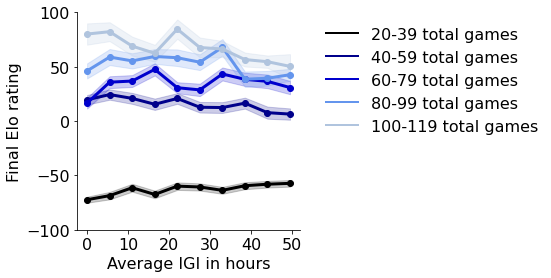

In [202]:
# Plot
colors = ['black', 'darkblue', 'mediumblue', 'cornflowerblue', 'lightsteelblue']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='20-39 total games'),Line2D([0], [0], color=colors[1], lw=2, label='40-59 total games'), Line2D([0], [0], color=colors[2], lw=2, label='60-79 total games'), Line2D([0], [0], color=colors[3], lw=2, label='80-99 total games'),Line2D([0], [0], color=colors[4], lw=2, label='100-119 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar(bin_edges[:-1], bin_means20, marker='o', color='black', lw=3, label='20-39 total games')
ax.errorbar(bin_edges[:-1], bin_means40, marker='o', color='darkblue', lw=3, label='40-59 total games')
ax.errorbar(bin_edges[:-1], bin_means60, marker='o', color='mediumblue', lw=3, label='60-79 total games')
ax.errorbar(bin_edges[:-1], bin_means80, marker='o', color='cornflowerblue', lw=3, label='80-99 total games')
ax.errorbar(bin_edges[:-1], bin_means100, marker='o', color='lightsteelblue', lw=3, label='100-119 total games')

ax.fill_between(bin_edges[:-1], bin_means20-bin_sem20, bin_means20+bin_sem20, color='black', alpha=0.2)
ax.fill_between(bin_edges[:-1], bin_means40-bin_sem40, bin_means40+bin_sem40, color='darkblue', alpha=0.2)
ax.fill_between(bin_edges[:-1], bin_means60-bin_sem60, bin_means60+bin_sem60, color='mediumblue', alpha=0.2)
ax.fill_between(bin_edges[:-1], bin_means80-bin_sem80, bin_means80+bin_sem80, color='cornflowerblue', alpha=0.2)
ax.fill_between(bin_edges[:-1], bin_means100-bin_sem100, bin_means100+bin_sem100, color='lightsteelblue', alpha=0.2)


ax.set_xlabel('Average IGI in hours')
ax.set_ylabel('Final Elo rating')
ax.set_ylim(-100, 100)
ax.set_xticks([0,10,20,30,40,50])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('IGI_finalelo.png', format='png', dpi=1000,bbox_inches = 'tight')

In [36]:
# Compute learning for high/low average IGI
block_highIGI = [[],[],[],[],[]]
block_lowIGI = [[],[],[],[],[]]

for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 100:
            IGI_ind = np.where(IGI_ID == curr_user)
            curr_IGI = IGI_gap[IGI_ind]/60/60
            if curr_IGI < 35:
                if ratingID[11] == '0':
                    block_lowIGI[0].append(curr_rating)
                elif ratingID[11:13] == '20':
                    block_lowIGI[1].append(curr_rating)
                elif ratingID[11:13] == '40':
                    block_lowIGI[2].append(curr_rating)
                elif ratingID[11:13] == '60':
                    block_lowIGI[3].append(curr_rating)
                elif ratingID[11:13] == '80':
                    block_lowIGI[4].append(curr_rating)
            elif curr_IGI > 35:
                if ratingID[11] == '0':
                    block_highIGI[0].append(curr_rating)
                elif ratingID[11:13] == '20':
                    block_highIGI[1].append(curr_rating)
                elif ratingID[11:13] == '40':
                    block_highIGI[2].append(curr_rating)
                elif ratingID[11:13] == '60':
                    block_highIGI[3].append(curr_rating)
                elif ratingID[11:13] == '80':
                    block_highIGI[4].append(curr_rating)

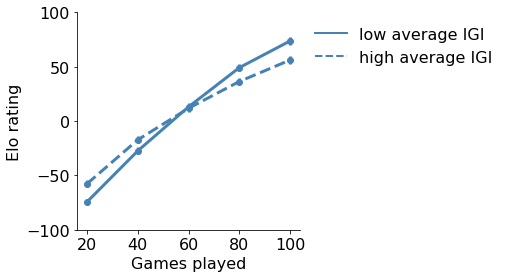

In [182]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color='steelblue', lw=2, label='low average IGI'), Line2D([0], [0], color='steelblue', lw=2, ls='--', label='high average IGI')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')
ax.errorbar([20,40,60,80,100], np.average(block_highIGI,axis=1), yerr = st.sem(block_highIGI,axis=1), marker='o', color='steelblue',lw=3,ls='--',)
ax.errorbar([20,40,60,80,100], np.average(block_lowIGI,axis=1), yerr = st.sem(block_lowIGI,axis=1), marker='o', color='steelblue',lw=3)
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_ylim(-100, 100)
ax.set_yticks([-100, -50, 0, 50, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('IGI_learning.png', format='png', dpi=1000,bbox_inches = 'tight')

In [59]:
# Compute learning values for regression
current_IGI_all = []
current_elos_all = []
current_games_all = []
    
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 100:
            IGI_ind = np.where(IGI_ID == curr_user)
            curr_IGI = IGI_gap[IGI_ind]/60/60
                        
            current_elos_all.append(curr_rating)
            current_games_all.append(int(ratingID[11]))
            current_IGI_all.append(curr_IGI[0])

In [60]:
# Convert to numpy array
current_IGI_all = np.asarray(current_IGI_all)
current_games_all = np.asarray(current_games_all)
current_elos_all = np.asarray(current_elos_all)

In [64]:
# Compute a linear regression
x_all = np.stack((current_IGI_all, current_games_all)).T
print_regression_table(x_all, current_elos_all, 'linear')

   Coefficients  Standard Errors   t values  Probabilities
0    -60.034149         2.902006 -20.687118       0.000000
1      0.037099         0.070988   0.522607       0.601255
2     16.306282         0.377052  43.246770       0.000000


In [78]:
# Compute average IGI, games played, and stopping probability for regression
IGI_all = []
games_all = []
stop_all = []

idx = 0
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    
    if curr_user in IGI_start20.keys():
        avg_IGI = block_IGIs[idx]/60/60
        idx += 1
        
        total_games = num_games[curr_user]
        if ratingID[11] == '0':
            if total_games < 40:
                stop_all.append(1)
                IGI_all.append(avg_IGI)
                games_all.append(20)
            else:
                stop_all.append(0)
                IGI_all.append(avg_IGI)
                games_all.append(20)
        elif ratingID[11:13] == '20':
            if total_games < 60:
                stop_all.append(1)
                IGI_all.append(avg_IGI)
                games_all.append(40)
            else:
                stop_all.append(0)
                IGI_all.append(avg_IGI)
                games_all.append(40)
        elif ratingID[11:13] == '40':
            if total_games < 80:
                stop_all.append(1)
                IGI_all.append(avg_IGI)
                games_all.append(60)
            else:
                stop_all.append(0)
                IGI_all.append(avg_IGI)
                games_all.append(60)
        elif ratingID[11:13] == '60':
            if total_games < 100:
                stop_all.append(1)
                IGI_all.append(avg_IGI)
                games_all.append(80)
            else:
                stop_all.append(0)
                IGI_all.append(avg_IGI)
                games_all.append(80)
        elif ratingID[11:13] == '80':
            if total_games < 120:
                stop_all.append(1)
                IGI_all.append(avg_IGI)
                games_all.append(100)
            else:
                stop_all.append(0)
                IGI_all.append(avg_IGI)
                games_all.append(100)
                
IGI_all = np.asarray(IGI_all)
games_all = np.asarray(games_all)
stop_all = np.asarray(stop_all)

In [84]:
# Compute a logistic regression
x_all2 = np.stack((IGI_all, games_all)).T
print_regression_table(x_all2, stop_all, 'logistic')

   Coefficients  Standard Errors     t values  Probabilities
0     -0.898643         0.002815  -319.230378            0.0
1      0.020209         0.000020  1008.663948            0.0
2     -0.004881         0.000051   -94.851526            0.0


## Response times

In [6]:
# Function to get the total game length (number of moves + timed out moves) for a single game
def get_game_length(data):
    game_length = 0
    for i in data['data']['rounds'][-1]['analytic']['events']:
        if i['stateString'] == 'Turn' or i['stateString'] == 'Timeout':
            game_length +=1
    return game_length

In [7]:
# Initialize a dictionary to hold the users as keys and the times they played each game
rt_user = {}
new_users = set()
rt_all = []

for game in games_filtered:
    with(open(game)) as f:
        data = json.load(f)
        
    # Get the user ID and time of game
    userID = data['bbuid']
    
    # Grab the total game length
    game_length = get_game_length(data)    
    
    # Loop through each of the user turns
    for turn in range(game_length):
        if turn % 2 == 0:
            # Grab the turn duration
            duration = data['data']['rounds'][turn]['duration']
            # Either initialize the key value or update the duration and turn count  
            rt_all.append(duration)
            
            if userID not in new_users:
                new_users.add(userID)
                rt_user[userID] = [duration]
            else:
                rt_user[userID].append(duration)

In [9]:
# Save out the rts
np.save("rt_user.npy", rt_user)
np.save("rt_all.npy", rt_all)

In [21]:
# Load the rts
rt_user = np.load('../saved_analyses/rt_user.npy', allow_pickle=True)
rt_all = np.load('../saved_analyses/rt_all.npy', allow_pickle=True)

In [38]:
# Filter the rts
filter_idx = np.argwhere((rt_all < 0) | (rt_all > 10000)).flatten()
rt_all_filtered = np.delete(rt_all, filter_idx)

In [41]:
# Convert to numpy array
rt_array = np.asarray(rt_all_filtered)/1000

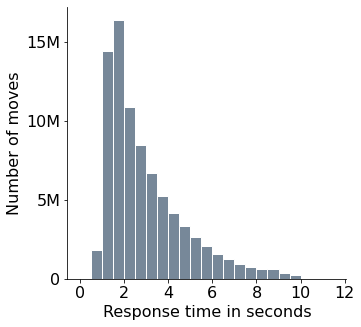

In [44]:
# Plot
bins = np.arange(0,12,.5)

fig, ax = plt.subplots()
ax.hist(rt_array, bins, edgecolor='white', color='lightslategray')
ax.set_xlabel('Response time in seconds')
ax.set_ylabel('Number of moves')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
ax.set_yticks([0, 5000000, 10000000, 15000000])
ax.set_yticklabels(['0', '5M', '10M', '15M'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('rt_all.png', format='png', dpi=1000,bbox_inches = 'tight')

## Opponent behavior

In [11]:
# Compute the opponent learning for total game groups
block20 = []
block40 = [[],[]]
block60 = [[],[],[]]
block80 = [[],[],[],[]]
block100 = [[],[],[],[],[]]

idx = 0
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_opprating = oppratings_avg[idx]
    idx += 1
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 20:
            block20.append(curr_opprating)

        elif block == 40:
            if ratingID[11] == '0':
                block40[0].append(curr_opprating)
            elif ratingID[11:13] == '20':
                block40[1].append(curr_opprating)

        elif block == 60:
            if ratingID[11] == '0':
                block60[0].append(curr_opprating)
            elif ratingID[11:13] == '20':
                block60[1].append(curr_opprating)
            elif ratingID[11:13] == '40':
                block60[2].append(curr_opprating)

        elif block == 80:
            if ratingID[11] == '0':
                block80[0].append(curr_opprating)
            elif ratingID[11:13] == '20':
                block80[1].append(curr_opprating)
            elif ratingID[11:13] == '40':
                block80[2].append(curr_opprating)
            elif ratingID[11:13] == '60':
                block80[3].append(curr_opprating)

        elif block == 100:
            if ratingID[11] == '0':
                block100[0].append(curr_opprating)
            elif ratingID[11:13] == '20':
                block100[1].append(curr_opprating)
            elif ratingID[11:13] == '40':
                block100[2].append(curr_opprating)
            elif ratingID[11:13] == '60':
                block100[3].append(curr_opprating)
            elif ratingID[11:13] == '80':
                block100[4].append(curr_opprating)

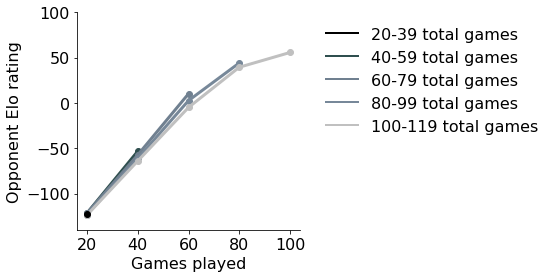

In [12]:
# Plot
colors = ['black', 'darkslategray', 'slategray', 'lightslategray', 'silver']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='20-39 total games'),Line2D([0], [0], color=colors[1], lw=2, label='40-59 total games'), Line2D([0], [0], color=colors[2], lw=2, label='60-79 total games'), Line2D([0], [0], color=colors[3], lw=2, label='80-99 total games'),Line2D([0], [0], color=colors[4], lw=2, label='100-119 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar([20,40], np.average(block40,axis=1), yerr = st.sem(block40,axis=1), marker='o', color='darkslategray', lw=3)
ax.errorbar([20,40,60], np.average(block60,axis=1),yerr = st.sem(block60,axis=1), marker='o', color='slategray', lw=3)
ax.errorbar([20,40,60,80], np.average(block80,axis=1), yerr = st.sem(block80,axis=1), marker='o', color='lightslategray', lw=3)
ax.errorbar([20,40,60,80,100], np.average(block100,axis=1), yerr = st.sem(block100,axis=1), marker='o', color='silver',lw=3)
ax.errorbar([20], np.average(block20), yerr = st.sem(block20), marker='o', color='black', lw=3)
ax.set_ylabel('Opponent Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([20, 40, 60, 80, 100])
# ax.set_xticklabels(['20', '40', '60', '80', '100'])
ax.set_ylim(-140,100)
# ax.set_yticks([-100, 0, 100, 200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('learning_opp.png', format='png', dpi=1000,bbox_inches = 'tight')

In [13]:
# Compute the relative ratings for total game groups
block20 = []
block40 = [[],[]]
block60 = [[],[],[]]
block80 = [[],[],[],[]]
block100 = [[],[],[],[],[]]

idx = 0
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    curr_opprating = oppratings_avg[idx]
    curr_relrating = curr_rating - curr_opprating
    idx += 1
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 20:
            block20.append(curr_relrating)

        elif block == 40:
            if ratingID[11] == '0':
                block40[0].append(curr_relrating)
            elif ratingID[11:13] == '20':
                block40[1].append(curr_relrating)

        elif block == 60:
            if ratingID[11] == '0':
                block60[0].append(curr_relrating)
            elif ratingID[11:13] == '20':
                block60[1].append(curr_relrating)
            elif ratingID[11:13] == '40':
                block60[2].append(curr_relrating)

        elif block == 80:
            if ratingID[11] == '0':
                block80[0].append(curr_relrating)
            elif ratingID[11:13] == '20':
                block80[1].append(curr_relrating)
            elif ratingID[11:13] == '40':
                block80[2].append(curr_relrating)
            elif ratingID[11:13] == '60':
                block80[3].append(curr_relrating)

        elif block == 100:
            if ratingID[11] == '0':
                block100[0].append(curr_relrating)
            elif ratingID[11:13] == '20':
                block100[1].append(curr_relrating)
            elif ratingID[11:13] == '40':
                block100[2].append(curr_relrating)
            elif ratingID[11:13] == '60':
                block100[3].append(curr_relrating)
            elif ratingID[11:13] == '80':
                block100[4].append(curr_relrating)

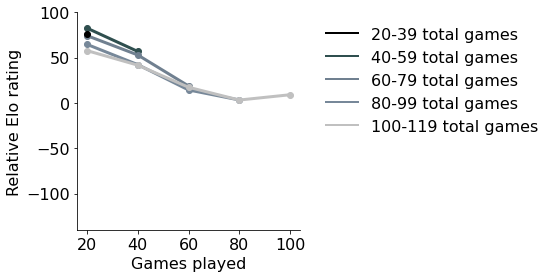

In [16]:
# Plot
colors = ['black', 'darkslategray', 'slategray', 'lightslategray', 'silver']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors[0], lw=2, label='20-39 total games'),Line2D([0], [0], color=colors[1], lw=2, label='40-59 total games'), Line2D([0], [0], color=colors[2], lw=2, label='60-79 total games'), Line2D([0], [0], color=colors[3], lw=2, label='80-99 total games'),Line2D([0], [0], color=colors[4], lw=2, label='100-119 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar([20,40], np.average(block40,axis=1), yerr = st.sem(block40,axis=1), marker='o', color='darkslategray', lw=3)
ax.errorbar([20,40,60], np.average(block60,axis=1),yerr = st.sem(block60,axis=1), marker='o', color='slategray', lw=3)
ax.errorbar([20,40,60,80], np.average(block80,axis=1), yerr = st.sem(block80,axis=1), marker='o', color='lightslategray', lw=3)
ax.errorbar([20,40,60,80,100], np.average(block100,axis=1), yerr = st.sem(block100,axis=1), marker='o', color='silver',lw=3)
ax.errorbar([20], np.average(block20), yerr = st.sem(block20), marker='o', color='black', lw=3)
ax.set_ylabel('Relative Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_ylim(-140,100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('learning_relopp.png', format='png', dpi=1000,bbox_inches = 'tight')

In [17]:
# Compute opponent learning and relative rating values for regression
current_elos_all = []
total_games_all = []
current_games_all = []
current_relelos_all = []

idx = 0
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = oppratings_avg[idx]    
    curr_relrating = int(ratingID[-4:])-mean_ai_elo - curr_rating
    idx += 1
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        total_games_all.append(total_games)

        current_elos_all.append(curr_rating)
        current_games_all.append(int(ratingID[11]))
        current_relelos_all.append(curr_relrating)

In [18]:
# Convert to numpy arrays
current_elos_all = np.asarray(current_elos_all)
total_games_all = np.asarray(total_games_all)
current_games_all = np.asarray(current_games_all)
current_relelos_all = np.asarray(current_relelos_all)

In [21]:
# Compute a linear regression
x_all = np.stack((current_games_all, total_games_all)).T
print_regression_table(x_all, current_elos_all, 'linear')

   Coefficients  Standard Errors    t values  Probabilities
0    -91.091087         0.153778 -592.353235            0.0
1     22.276241         0.052219  426.595520            0.0
2      0.019890         0.000158  126.219983            0.0


In [22]:
# Compute a linear regression
x_all = np.stack((current_games_all, total_games_all)).T
print_regression_table(x_all, current_relelos_all, 'linear')

   Coefficients  Standard Errors    t values  Probabilities
0     61.711726         0.309541  199.365056            0.0
1    -10.006217         0.105111  -95.196455            0.0
2     -0.011345         0.000317  -35.764920            0.0


In [85]:
# Compute relative ratings for regression
relrating_all = []
games_all = []
stop_all = []

idx = 0
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    curr_opprating = oppratings_avg[idx]
    curr_relrating = curr_rating - curr_opprating
    idx += 1
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        if ratingID[11] == '0':
            if total_games < 40:
                stop_all.append(1)
                relrating_all.append(curr_relrating)
                games_all.append(20)
            else:
                stop_all.append(0)
                relrating_all.append(curr_relrating)
                games_all.append(20)
        elif ratingID[11:13] == '20':
            if total_games < 60:
                stop_all.append(1)
                relrating_all.append(curr_relrating)
                games_all.append(40)
            else:
                stop_all.append(0)
                relrating_all.append(curr_relrating)
                games_all.append(40)
        elif ratingID[11:13] == '40':
            if total_games < 80:
                stop_all.append(1)
                relrating_all.append(curr_relrating)
                games_all.append(60)
            else:
                stop_all.append(0)
                relrating_all.append(curr_relrating)
                games_all.append(60)
        elif ratingID[11:13] == '60':
            if total_games < 100:
                stop_all.append(1)
                relrating_all.append(curr_relrating)
                games_all.append(80)
            else:
                stop_all.append(0)
                relrating_all.append(curr_relrating)
                games_all.append(80)
        elif ratingID[11:13] == '80':
            if total_games < 120:
                stop_all.append(1)
                relrating_all.append(curr_relrating)
                games_all.append(100)
            else:
                stop_all.append(0)
                relrating_all.append(curr_relrating)
                games_all.append(100)
                
relrating_all = np.asarray(relrating_all)
games_all = np.asarray(games_all)
stop_all = np.asarray(stop_all)

In [88]:
# Compute a logistic regression
x_all2 = np.stack((relrating_all, games_all)).T
print_regression_table(x_all2, stop_all, 'logistic')

   Coefficients  Standard Errors    t values  Probabilities
0      0.594087         0.002737  217.048002            0.0
1      0.000705         0.000011   63.935274            0.0
2     -0.018498         0.000058 -320.404129            0.0


In [279]:
# Create a dictionary with user IDs and opponent trajectories for all users
opptrajectories_dict = dict((el,[]) for el in over20_users)

for userID in opptrajectories_dict.keys():
    total_games = num_games[userID]
    last_block = int(np.floor(total_games/20)*20)
    curr_trajectory = []
    
    for ii in range(0,last_block,20):
        idx = 0
        for ratingID in user_ID:
            if userID == ratingID[0:10] and ii == int(ratingID[11:11+len(str(ii))]):
                curr_trajectory.append(oppratings_avg[idx])
            idx += 1

    opptrajectories_dict[userID] = curr_trajectory

In [280]:
# Save out the opponent trajectories
np.save("opptrajectories_dict.npy", opptrajectories_dict)

In [24]:
# Load the opponent trajectories
opptrajectories_dict = np.load('../saved_analyses/opptrajectories_dict.npy', allow_pickle=True).flat[0]

In [27]:
# Compute the change in Elos from the trajectories
rel_oppelos = []
stopping = []
games_played = []

for userID in opptrajectories_dict.keys():
    curr_trajectory = trajectories_dict[userID]
    curr_opptrajectory = opptrajectories_dict[userID]
    for i in range(len(curr_trajectory)):
        rel_oppelos.append(curr_trajectory[i]-curr_opptrajectory[i])
        games_played.append(i*20+20)
        if i != len(curr_trajectory)-1:
            stopping.append(0)
        else:
            stopping.append(1)

In [28]:
# Compute the mean and sem binned for stopping vs. change in elo
bin_means, bin_edges, binnumber = binned_statistic(rel_oppelos, stopping, statistic='mean', bins=10, range=(-500, 500))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(rel_oppelos, stopping, statistic=st.sem, bins=10, range=(-500, 500))

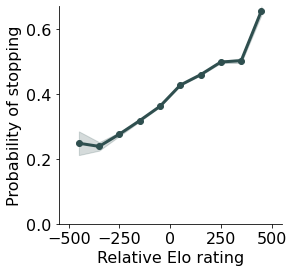

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1]+50, bin_means, marker='o', color='darkslategray', lw=3)
ax.fill_between(bin_edges[:-1]+50, bin_means-bin_sem, bin_means+bin_sem, color='darkslategray', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Relative Elo rating')
ax.set_xlim(-550,550)
ax.set_ylim(0,0.67)
ax.set_xticks([-500, -250, 0, 250, 500])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('stopping_relelo.png', format='png', dpi=1000,bbox_inches = 'tight')

In [30]:
# Compute the change in Elos from the trajectories
change_relativeelos = []
stopping = []
games_played = []

for userID in opptrajectories_dict.keys():
    curr_trajectory = trajectories_dict[userID]
    curr_opptrajectory = opptrajectories_dict[userID]
    for i in range(len(curr_trajectory)):
        if i == 0:
            pass
        else:
            diff_self = curr_trajectory[i]-curr_trajectory[i-1]
            diff_opp = curr_opptrajectory[i]-curr_opptrajectory[i-1]
            change_relativeelos.append(diff_self-diff_opp)
            games_played.append(i*20+20)
            if i != len(curr_trajectory)-1:
                stopping.append(0)
            else:
                stopping.append(1)

In [31]:
# Compute the mean and sem binned for stopping vs. change in elo
bin_means, bin_edges, binnumber = binned_statistic(change_relativeelos, stopping, statistic='mean', bins=10, range=(-500, 500))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(change_relativeelos, stopping, statistic=st.sem, bins=10, range=(-500, 500))

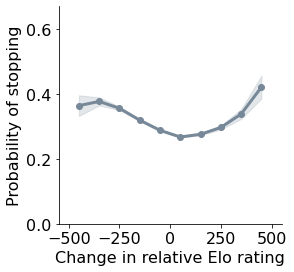

In [32]:
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1]+50, bin_means, marker='o', color='lightslategray', lw=3)
ax.fill_between(bin_edges[:-1]+50, bin_means-bin_sem, bin_means+bin_sem, color='lightslategray', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Change in relative Elo rating')
ax.set_xlim(-550,550)
ax.set_ylim(0,0.67)
ax.set_xticks([-500, -250, 0, 250, 500])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('stopping_changerelelo.png', format='png', dpi=1000,bbox_inches = 'tight')

In [33]:
# Compute a logistic regression
print_regression_table(np.asarray(change_relativeelos).reshape(-1,1), stopping, 'logistic')

   Coefficients  Standard Errors    t values  Probabilities
0     -0.903080         0.001329 -679.627103            0.0
1     -0.000681         0.000011  -62.568390            0.0


In [280]:
# Compute learning for high/low relative relative ratings
block_highopp = [[],[],[],[],[]]
block_lowopp = [[],[],[],[],[]]
    
idx = 0
for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    curr_opprating = oppratings_avg[idx]
    curr_relrating = curr_rating - curr_opprating
    idx += 1
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 100:
            if curr_relrating < 0:
                if ratingID[11] == '0':
                    block_lowopp[0].append(curr_rating)
                elif ratingID[11:13] == '20':
                    block_lowopp[1].append(curr_rating)
                elif ratingID[11:13] == '40':
                    block_lowopp[2].append(curr_rating)
                elif ratingID[11:13] == '60':
                    block_lowopp[3].append(curr_rating)
                elif ratingID[11:13] == '80':
                    block_lowopp[4].append(curr_rating)
            elif curr_relrating > 0:
                if ratingID[11] == '0':
                    block_highopp[0].append(curr_rating)
                elif ratingID[11:13] == '20':
                    block_highopp[1].append(curr_rating)
                elif ratingID[11:13] == '40':
                    block_highopp[2].append(curr_rating)
                elif ratingID[11:13] == '60':
                    block_highopp[3].append(curr_rating)
                elif ratingID[11:13] == '80':
                    block_highopp[4].append(curr_rating)

In [281]:
# Compute averages
mean_highopp = [np.average(sub_list) for sub_list in block_highopp]
mean_lowopp = [np.average(sub_list) for sub_list in block_lowopp]
sem_highopp = [st.sem(sub_list) for sub_list in block_highopp]
sem_lowopp = [st.sem(sub_list) for sub_list in block_lowopp]

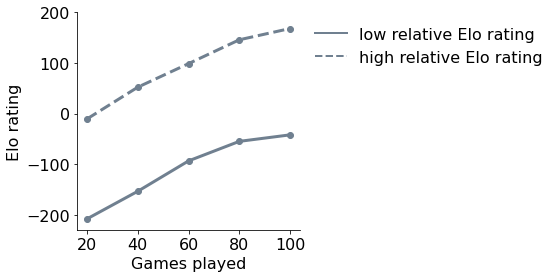

In [284]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color='slategray', lw=2, label='low relative Elo rating'), Line2D([0], [0], color='slategray', lw=2, ls='--', label='high relative Elo rating')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1,1), loc='upper left')
ax.errorbar([20,40,60,80,100], mean_highopp, yerr=sem_highopp, marker='o', color='slategray',lw=3,ls='--',)
ax.errorbar([20,40,60,80,100], mean_lowopp, yerr=sem_lowopp, marker='o', color='slategray',lw=3)
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_yticks([-200, -100, 0, 100, 200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_learning.png', format='png', dpi=1000,bbox_inches = 'tight')

In [89]:
# Compute learning for high/low relative relative ratings for regression
current_relrating_all = []
current_elos_all = []
current_games_all = []

idx = 0

for ratingID in user_ID:
    curr_user = ratingID[0:10]
    curr_rating = int(ratingID[-4:])-mean_ai_elo
    curr_opprating = oppratings_avg[idx]
    curr_relrating = curr_rating - curr_opprating
    idx += 1
    
    if curr_user[0].isnumeric():
        print(curr_user)
    else:
        total_games = num_games[curr_user]
        block = int(np.floor(total_games/20)*20)

        if block == 100:                        
            current_elos_all.append(curr_rating)
            current_games_all.append(int(ratingID[11]))
            current_relrating_all.append(curr_relrating)

In [90]:
# Convert to numpy arrays
current_relrating_all = np.asarray(current_relrating_all)
current_elos_all = np.asarray(current_elos_all)
current_games_all = np.asarray(current_games_all)

In [91]:
# Compute a linear regression
x_all = np.stack((current_relrating_all, current_games_all)).T
print_regression_table(x_all, current_elos_all, 'linear')

   Coefficients  Standard Errors    t values  Probabilities
0   -113.523670         0.603036 -188.253594            0.0
1      1.031657         0.002772  372.205960            0.0
2     23.312878         0.120863  192.886074            0.0


## Plotting very experienced trajectories

In [233]:
# Put all users with at least 20 games in a set
over1000_users = set()
for user in num_games:
    if num_games[user] >= 1000:
        over1000_users.add(user)

In [264]:
# Create a dictionary with user IDs and game trajectories for all users
temp = random.choices(list(over1000_users),k=4)

trajectories_temp = dict((el,[]) for el in temp)

for userID in trajectories_temp.keys():
    total_games = num_games[userID]
    last_block = int(np.floor(total_games/20)*20)
    curr_trajectory = []
    
    for ii in range(0,last_block,20):
        for ratingID in user_ID:
            if userID == ratingID[0:10] and ii == int(ratingID[11:11+len(str(ii))]):
                curr_trajectory.append(int(ratingID[-4:])-3104)

    trajectories_temp[userID] = curr_trajectory

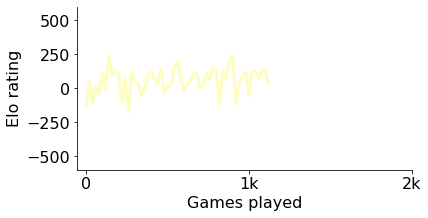

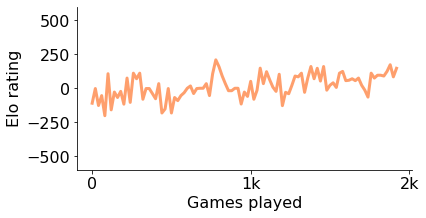

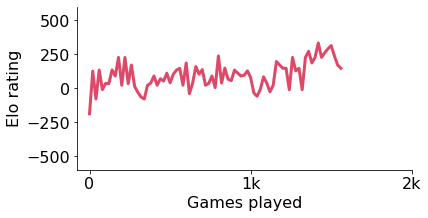

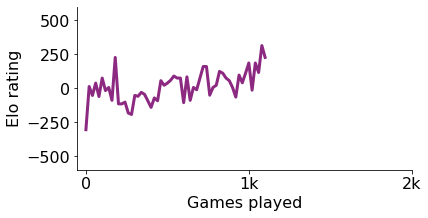

In [265]:
# Plot some trajectories
colors = mcp.gen_color(cmap="magma",n=6)

i=4
for user in trajectories_temp:
    fig, ax = plt.subplots(figsize=(6,3))
    x = np.arange(0,len(trajectories_dict[user]))*20
    ax.plot(x, trajectories_temp[user], colors[i+1],lw=3)
    i -= 1
    ax.set_ylabel('Elo rating')
    ax.set_xlabel('Games played')
    ax.set_xticks(np.arange(0,2500,1000))
    ax.set_xticklabels(['0', '1k', '2k'])
    ax.set_ylim(-600,600)
    ax.set_yticks([-500, -250, 0, 250, 500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#     plt.savefig('trajectories'+str(i)+'.png', format='png', dpi=1000,bbox_inches = 'tight')

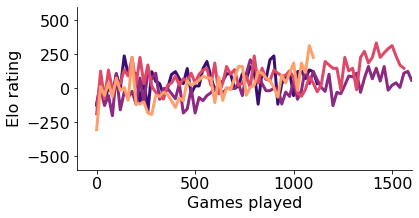

In [267]:
# Plot some trajectories
colors = mcp.gen_color(cmap="magma",n=6)

fig, ax = plt.subplots(figsize=(6,3))
count = 0
for user in trajectories_temp:
    x = np.arange(0,len(trajectories_dict[user]))*20
    ax.plot(x, trajectories_temp[user], colors[count+1],lw=3)
    count += 1
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xlim(-100, 1600)
ax.set_xticks([0, 500, 1000, 1500])
ax.set_ylim(-600,600)
ax.set_yticks([-500, -250, 0, 250, 500])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('trajectories.png', format='png', dpi=1000,bbox_inches = 'tight')

In [268]:
# Display the selected users
trajectories_temp.keys()

dict_keys(['mChJonKWSf', 'AUYAjxUKep', 'cSunUNSngj', 'muwTLmabpA'])

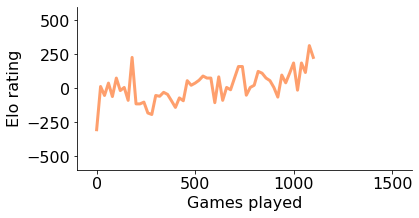

In [315]:
# Plot a trajectory individually
colors = mcp.gen_color(cmap="magma",n=6)

fig, ax = plt.subplots(figsize=(6,3))
count = 3
user = 'muwTLmabpA'
x = np.arange(0,len(trajectories_dict[user]))*20
ax.plot(x, trajectories_temp[user], colors[count+1],lw=3)
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_xlim(-100, 1600)
ax.set_xticks([0, 500, 1000, 1500])
ax.set_ylim(-600,600)
ax.set_yticks([-500, -250, 0, 250, 500])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('trajectories_single.png', format='png', dpi=1000,bbox_inches = 'tight')